# Toxic Comment Classification Challenge
# Model Training Routine

This notebook outlines the complete model training process for the toxic comment classification task. It begins with loading the dataset, followed by splitting the data into training, validation, and test sets. We also calculate class weights to address data imbalance and improve model performance across all toxicity categories.

Next, the learning rate finder is employed to determine the optimal learning rate for training. Once the model is trained, we evaluate its performance using metrics, including accuracy, recall and F1 score.

## Environment Setup and Data Loading

In [1]:
import os
import sys

import pandas as pd
import numpy as np
from tqdm import tqdm

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.utils import resample
from sklearn.utils.class_weight import compute_class_weight

import torch
from transformers import DistilBertTokenizer
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, Dataset
import torch.optim as optim
import pytorch_lightning as pl


sys.path.append('../')
from utils import compare_datasets, compute_toxic_nontoxic_weights
from utils import CustomDataset
from utils import Extended_Model
from utils import Main_Model_Multihead
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

import matplotlib.pyplot as plt

from pytorch_lightning.loggers import TensorBoardLogger

DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.


cuda:0


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MiestoMeska\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\MiestoMeska\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
train_data = pd.read_csv('../data/augmented_data.csv')
print(train_data.head())

                 id  toxic  severe_toxic  obscene  threat  insult  \
0  0000997932d777bf      0             0        0       0       0   
1  000103f0d9cfb60f      0             0        0       0       0   
2  000113f07ec002fd      0             0        0       0       0   
3  0001b41b1c6bb37e      0             0        0       0       0   
4  0001d958c54c6e35      0             0        0       0       0   

   identity_hate                                       cleaned_text  
0              0  explanation why the edits made under my userna...  
1              0  daww he match this background colour i am seem...  
2              0  hey man i am really not trying to edit war it ...  
3              0  more i cannot make any real suggestion on impr...  
4              0  you sir are my hero any chance you remember wh...  


In [3]:
train_data.drop(['id'], inplace=True, axis=1)

In [4]:
train_data['is_toxic'] = train_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].max(axis=1)

In [5]:
binary_label_column = 'is_toxic'
label_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

## Splitting the Data

We use StratifiedShuffleSplit to ensure that the distribution of toxic and non-toxic comments is consistent across all splits. The initial split separates the data into training and a temporary set, which is then further split into validation and test sets, resulting in a well-stratified dataset for training and evaluation.

To address the imbalance between toxic and non-toxic comments in the training set, we undersample the non-toxic comments. By resampling the non-toxic class to match the number of toxic samples, we ensure a more balanced training set.

In [6]:
torch.set_float32_matmul_precision('medium')

In [7]:
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=123)

for train_idx, temp_idx in strat_split.split(train_data, train_data['is_toxic']):
    train_df = train_data.iloc[train_idx]
    temp_df = train_data.iloc[temp_idx]

val_test_split = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=123)

for val_idx, test_idx in val_test_split.split(temp_df, temp_df['is_toxic']):
    val_df = temp_df.iloc[val_idx]
    test_df = temp_df.iloc[test_idx]

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(f"Training Dataset: {train_df.shape}")
print(f"Validation Dataset: {val_df.shape}")
print(f"Test Dataset: {test_df.shape}")

Training Dataset: (113140, 8)
Validation Dataset: (24244, 8)
Test Dataset: (24245, 8)


In [8]:
toxic_df = train_df[train_df['is_toxic'] == 1]
non_toxic_df = train_df[train_df['is_toxic'] == 0]

undersampled_non_toxic_df = resample(non_toxic_df,
                                     replace=False,
                                     n_samples=len(toxic_df),
                                     random_state=123)

undersampled_train_df = pd.concat([toxic_df, undersampled_non_toxic_df])

undersampled_train_df = undersampled_train_df.sample(frac=1, random_state=123).reset_index(drop=True)

print(f"Original Training Set Shape: {train_df.shape}")
print(f"Undersampled Training Set Shape: {undersampled_train_df.shape}")

Original Training Set Shape: (113140, 8)
Undersampled Training Set Shape: (27580, 8)


In [9]:
compare_datasets(undersampled_train_df, val_df, test_df, label_columns)


--- Binary Toxic vs. Non-Toxic Distribution ---

Training Set:
is_toxic
0    50.0
1    50.0
Name: proportion, dtype: float64

Validation Set:
is_toxic
0    87.811417
1    12.188583
Name: proportion, dtype: float64

Test Set:
is_toxic
0    87.81192
1    12.18808
Name: proportion, dtype: float64

--- Distribution of Each Toxic Class ---

Training Set:
toxic            47.280638
severe_toxic      8.404641
obscene          28.448151
threat            4.419869
insult           26.870921
identity_hate     7.403916
dtype: float64

Validation Set:
toxic            11.495628
severe_toxic      2.025243
obscene           6.941924
threat            1.002310
insult            6.743937
identity_hate     1.831381
dtype: float64

Test Set:
toxic            11.420912
severe_toxic      1.988039
obscene           6.850897
threat            1.142504
insult            6.475562
identity_hate     1.810683
dtype: float64


The data splitting and resampling process successfully balanced the training set for the binary toxic vs. non-toxic classification, resulting in an equal distribution (50% each). However, the validation and test sets maintain the original class imbalance, with approximately 12% toxic and 88% non-toxic comments, which reflects the real-world distribution.

For the toxic subcategories, the training set is more balanced, though some categories like threat and identity hate still remain underrepresented. The validation and test sets retain the lower proportions of toxic subcategories, which is important for evaluating the model's ability to generalize. The balance achieved in the training data should help the model learn effectively across all toxicity classes, while the validation and test sets provide a realistic scenario for model evaluation.

## Class Weight Calculation

In this section, we calculate class weights to handle class imbalance for both the binary toxic vs. non-toxic classification and the multilabel toxic categories. The binary class weights are computed based on the balanced distribution of toxic and non-toxic comments in the undersampled training data. Additionally, for the toxic-only samples, we calculate class weights for each of the six toxic labels to ensure the model places more emphasis on the underrepresented classes during training.

In [10]:
label_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

binary_class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=undersampled_train_df['is_toxic']
)

binary_weights_tensor = torch.tensor(binary_class_weights, dtype=torch.float32)
print("Binary Class Weights (Toxic vs Non-Toxic):", binary_weights_tensor)

toxic_samples = undersampled_train_df[undersampled_train_df['is_toxic'] == 1]

multilabel_class_weights = {}
for label in label_columns:
    multilabel_class_weights[label] = compute_class_weight(
        class_weight='balanced',
        classes=np.array([0, 1]),
        y=toxic_samples[label]
    )

class_weights_tensor = torch.tensor(
    [multilabel_class_weights[label][1] for label in label_columns], dtype=torch.float32
)
print("Multilabel Class Weights (Toxic Comments Only):", class_weights_tensor)

Binary Class Weights (Toxic vs Non-Toxic): tensor([1., 1.])
Multilabel Class Weights (Toxic Comments Only): tensor([0.5288, 2.9745, 0.8788, 5.6563, 0.9304, 3.3766])


The binary class weights for toxic vs. non-toxic comments are balanced, indicating an equal representation in the undersampled training data. For the multilabel toxic classes, higher weights are assigned to underrepresented categories, reflecting the imbalance in their distribution.

## Setting up Hyperparameters and  Data Loaders

In [11]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
logger = TensorBoardLogger("tb_logs", name="multihead_model")

hparams = {
    'learning_rate': 1e-4,
    'batch_size': 16,
    'gradient_accumulation_steps': 32
}

max_len = 192
num_workers=10

text_column = 'cleaned_text'
binary_label_column = 'is_toxic'

train_dataset = CustomDataset(undersampled_train_df, tokenizer, max_len, label_columns, binary_label_column, text_column)
val_dataset = CustomDataset(val_df, tokenizer, max_len, label_columns, binary_label_column, text_column)
test_dataset = CustomDataset(test_df, tokenizer, max_len, label_columns, binary_label_column, text_column)

train_loader = DataLoader(train_dataset, batch_size=hparams['batch_size'], shuffle=True, num_workers=num_workers, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=hparams['batch_size'], shuffle=False, num_workers=num_workers, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=hparams['batch_size'], shuffle=False, num_workers=num_workers, persistent_workers=True)


C:\Users\MiestoMeska\anaconda3\envs\TC_4\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## Learning Rate Finder implementation

In this section, we use the learning rate finder to determine the optimal learning rate for training our model. The PyTorch Lightning Tuner is used to conduct a learning rate search, testing various learning rates by observing how the loss changes during training. The plot shows a characteristic "U-shape" curve, indicating that the optimal learning rate is at the point where the loss starts to decrease before it rises again.

In [12]:
def perform_lr_finder(model, trainer, train_loader, val_loader):
    tuner = pl.tuner.Tuner(trainer)
    lr_finder = tuner.lr_find(
        model,
        train_dataloaders=train_loader,
        val_dataloaders=val_loader,
        min_lr=1e-8,
        max_lr=1e-1,
        num_training=200
    )

    fig = lr_finder.plot(suggest=True)
    plt.show()

    suggested_lr = lr_finder.suggestion()
    print(f"Suggested Learning Rate: {suggested_lr}")
    
    model.learning_rate = suggested_lr
    
    return suggested_lr

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\MiestoMeska\anaconda3\envs\TC_4\lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MultilabelAccuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)  # noqa: B028
C:\Users\MiestoMeska\anaconda3\envs\TC_4\lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MultilabelF1Score was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)  # noqa: B028


Finding best initial lr:   0%|          | 0/200 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
Learning rate set to 0.0006237348354824198
Restoring states from the checkpoint path at C:\Users\MiestoMeska\Desktop\Mokslai\TC\Module4\Sprint_2\Project\vruzga-DL.2.5\notebooks\.lr_find_d7b06bea-6d1d-45a1-b0d5-18ff2b9e4da9.ckpt
Restored all states from the checkpoint at C:\Users\MiestoMeska\Desktop\Mokslai\TC\Module4\Sprint_2\Project\vruzga-DL.2.5\notebooks\.lr_find_d7b06bea-6d1d-45a1-b0d5-18ff2b9e4da9.ckpt


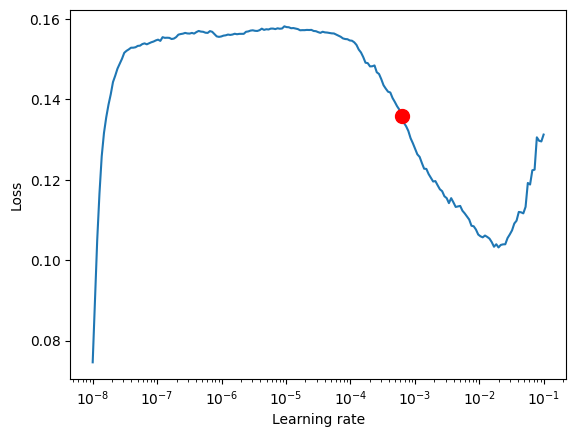

Suggested Learning Rate: 0.0006237348354824198


In [13]:
multihead_model = Main_Model_Multihead(
    freeze_base=True,
    num_labels=6,
    learning_rate=1e-5,
    class_weights=class_weights_tensor,
    binary_weights=binary_weights_tensor[1:]
)

trainer = pl.Trainer(
    logger=logger,
    accumulate_grad_batches=hparams['gradient_accumulation_steps'],
    max_epochs=9,
    enable_checkpointing=False,
    enable_progress_bar=False
)

suggested_lr = perform_lr_finder(multihead_model, trainer, train_loader, val_loader)

## Model training setup with Callbacks

In this section, we set up the checkpointing and early stopping mechanisms to monitor and save the best models during training. We implement two checkpoint callbacks: one for monitoring the binary classification performance (based on the val_binary_f1 score) and another for monitoring the multi-label classification performance (based on the val_multilabel_f1 score).

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\MiestoMeska\anaconda3\envs\TC_4\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\MiestoMeska\Desktop\Mokslai\TC\Module4\Sprint_2\Project\vruzga-DL.2.5\models\multihead exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                      | Type               | Params | Mode 
--------------------------------------------------------------------------
0  | bert                      | DistilBertModel    | 66.4 M | eval 
1  | binary_classifier         | Sequential         | 558 K  | train
2  | toxic_classifier          | Sequential         | 558 K  | train
3  | severe_toxic_classifier   | Sequential         | 558 K  | train
4  | obscene_classifier        | Sequential         | 558 K  | train
5  | threat_classifier         | Sequential         | 558 K  | train
6  | insult_classifier       

Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

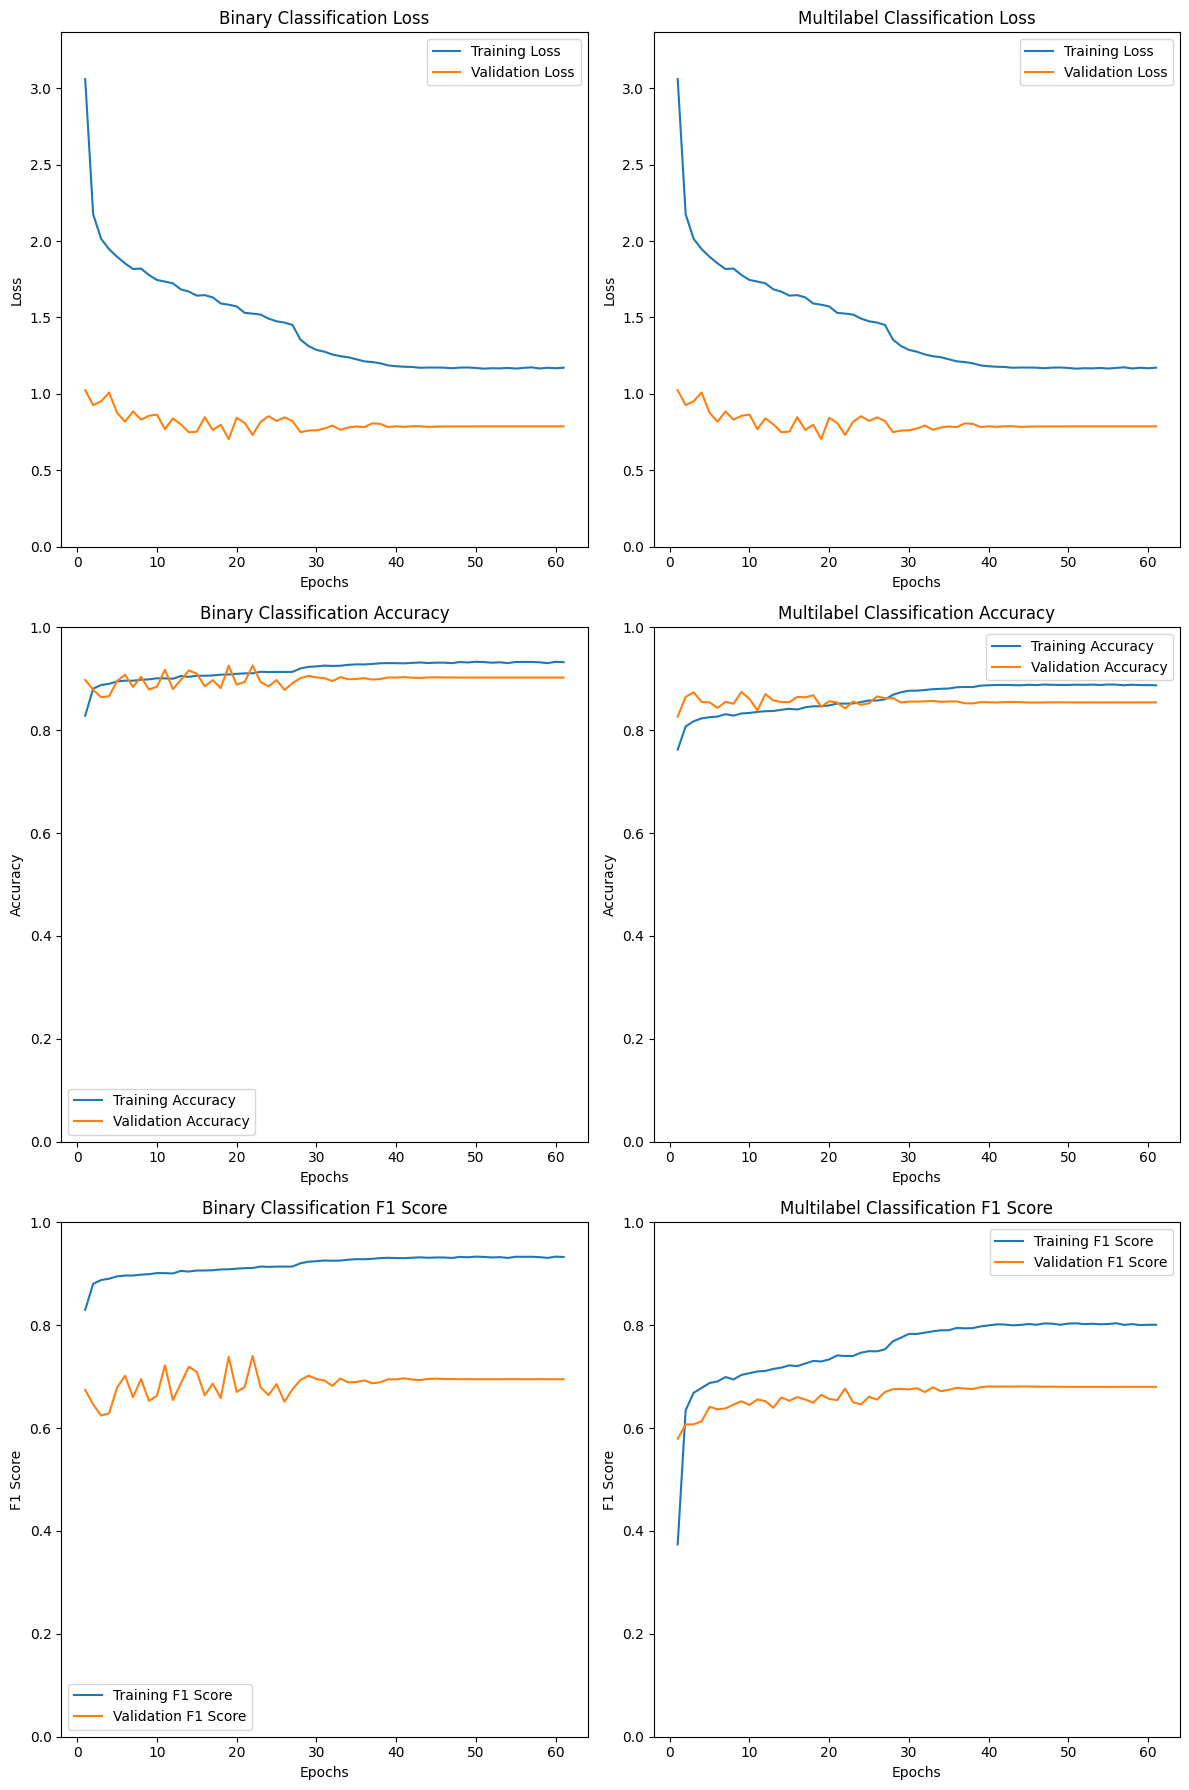

In [14]:
multihead_model.learning_rate = suggested_lr
hparams['learning_rate'] = suggested_lr
checkpoint_callback_binary = ModelCheckpoint(
    monitor='val_binary_f1_epoch',
    dirpath='../models/multihead/',
    filename='multihead_best_binary',
    save_top_k=1,
    mode='max'
)

checkpoint_callback_multilabel = ModelCheckpoint(
    monitor='val_multilabel_f1_epoch',
    dirpath='../models/multihead/',
    filename='multihead_best_multilabel',
    save_top_k=1,
    mode='max'
)

early_stopping_callback = EarlyStopping(
    monitor='train_loss',
    patience=10,
    mode='min'
)

trainer = pl.Trainer(
    logger=logger,
    accumulate_grad_batches=hparams['gradient_accumulation_steps'],
    max_epochs=99,
    callbacks=[early_stopping_callback, checkpoint_callback_binary, checkpoint_callback_multilabel]
)

logger.log_hyperparams(hparams)
trainer.fit(multihead_model, train_dataloaders=train_loader, val_dataloaders=val_loader)

In [16]:
evaluate_model(val_loader, multihead_model)


Binary Classification Metrics (Toxic vs Non-Toxic):
Binary Confusion Matrix:
[[19180  2109]
 [  258  2697]]
Binary Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.90      0.94     21289
         1.0       0.56      0.91      0.70      2955

    accuracy                           0.90     24244
   macro avg       0.77      0.91      0.82     24244
weighted avg       0.93      0.90      0.91     24244


Multilabel Classification Metrics (Toxicity Classes):

Confusion Matrix for toxic:
[[20087  1370]
 [  407  2380]]
Precision: 0.6347, Recall: 0.8540, F1-Score: 0.7282

Confusion Matrix for severe_toxic:
[[23367   386]
 [  135   356]]
Precision: 0.4798, Recall: 0.7251, F1-Score: 0.5775

Confusion Matrix for obscene:
[[22192   369]
 [  400  1283]]
Precision: 0.7766, Recall: 0.7623, F1-Score: 0.7694

Confusion Matrix for threat:
[[23796   205]
 [   39   204]]
Precision: 0.4988, Recall: 0.8395, F1-Score: 0.6258

Confusion Matrix for